# Reconstruction of DOSY NMR signals 
**Authors:** Bastien LE CHENADEC and Theïlo TERRISSE

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import lambertw

# Common functions

## Fixed-point algorithms

In [2]:
def gradient_descent(
    f,
    df,
    x0,
    lr_min,
    lr_max=None,
    tol=1e-8,
    max_iter=500000,
    print_every=1000,
    verbose=True,
):
    """lr should be taken strictly smaller than 2/L, where L is the Lipschitz constant of df."""
    if lr_max is None:
        lr_max = lr_min
    x = x0
    for i in range(max_iter):
        if verbose and i % print_every == 0:
            print(f"Value after {i} iterations: {f(x)}", end="\r")
        lr = lr_max - (lr_max - lr_min) * i / max_iter
        grad = df(x)
        x_new = x - lr * grad
        if np.linalg.norm(x_new - x) < tol:
            if verbose:
                print()
                print(f"Early convergence after {i} iterations")
            break
        x = x_new
    if verbose:
        print(f"Final value: {f(x)}")
    return x_new


def projected_gradient_descent(
    f, df, x0, xmin, xmax, L, lr=0.01, tol=1e-8, max_iter=500000, verbose=True
):
    """lr should be taken strictly smaller than 2/L, where L is the Lipschitz constant of df."""
    assert 0 < lr < 2 / L
    delta = 2 - L * lr / 2
    lambd_min = 0.1 * delta
    lambd_max = 0.9 * delta
    x = x0
    for i in range(max_iter):
        if verbose and i % 1000 == 0:
            print(f"Value after {i} iterations: {f(x)}", end="\r")
        lambd = lambd_max - (lambd_max - lambd_min) * i / max_iter
        y = x - lr * df(x)
        projected_y = np.clip(y, xmin, xmax)
        x_new = x + lambd * (projected_y - x)
        if np.linalg.norm(x_new - x) < tol:
            if verbose:
                print()
                print(f"Early convergence after {i} iterations")
            break
        x = x_new
    if verbose:
        print(f"Final value: {f(x)}")
    return x_new


def forward_backward(
    f, g, dg, proxgamf, x0, gamma, nu, tol=1e-6, max_iter=500000, verbose=True
):
    assert 0 < gamma < 2 / nu
    delta = 2 - nu * gamma / 2
    lambd_min = 0.1 * delta
    lambd_max = 0.9 * delta
    x = x0
    for i in range(max_iter):
        if verbose and i % 1000 == 0:
            print(f"Value after {i} iterations: {f(x)+g(x)}", end="\r")
        lambd = lambd_max - (lambd_max - lambd_min) * i / max_iter
        y = x - gamma * dg(x)
        x_new = x + lambd * (proxgamf(y, gamma) - x)
        if np.linalg.norm(x_new - x) < tol:
            if verbose:
                print()
                print(f"Early convergence after {i} iterations")
            break
        x = x_new
    if verbose:
        print(f"Final value: {f(x)+g(x)}")
    return x_new


def douglas_rachford(
    f, g, proxgamf, proxgamg, x0, gamma, tol=1e-6, max_iter=500000, verbose=True
):
    lambd = 1
    x = x0
    lambd_min = 0.2
    lambd_max = 2
    for i in range(max_iter):
        if verbose and i % 1000 == 0:
            print(f"Value after {i} iterations: {f(x)+g(x)}", end="\r")
        lambd = lambd_max - (lambd_max - lambd_min) * i / max_iter
        y = proxgamg(x, gamma)
        z = proxgamf(2 * y - x, gamma)
        x_new = x + lambd * (z - y)
        if np.linalg.norm(x_new - x) < tol:
            if verbose:
                print()
                print(f"Early convergence after {i} iterations")
            break
        x = x_new
    if verbose:
        print(f"Final value: {f(x)+g(x)}")
    return x_new

def ppxa(
    g1, g2, proxgamg1, proxgamg2, L1, L2, x01, x02, gamma, tol=1e-6, max_iter=50000, verbose=True
):
    """ Implemented only for the sum of m=2 functions."""
    lambd = 1
    lambd_min = 0.2
    lambd_max = 2
    x1, x2 = x01, x02
    proj1 = np.linalg.inv(L1.T @ L1 + L2.T @ L2) @ L1.T
    proj2 = np.linalg.inv(L1.T @ L1 + L2.T @ L2) @ L2.T
    v = proj1 @ x01 + proj2 @ x02
    for i in range(max_iter):
        if verbose and i % 1000 == 0:
            print(f"Value after {i} iterations: {g1(L1@v)+g2(L2@v)}", end="\r")
        lambd = lambd_max - (lambd_max - lambd_min) * i / max_iter
        y1 = proxgamg1(x1, gamma)
        y2 = proxgamg2(x2, gamma)
        c = proj1 @ y1 + proj2 @ y2
        x1_new = x1 + lambd * (L1@(2*c - v) - y1)
        x2_new = x2 + lambd * (L2@(2*c - v) - y2)
        v_new = v + lambd * (c - v)
        if np.linalg.norm(v_new - v) < tol:
            if verbose:
                print()
                print(f"Early convergence after {i} iterations")
            break
        x1 = x1_new
        x2 = x2_new
        v = v_new
    if verbose:
        print(f"Final value: {g1(L1@v)+g2(L2@v)}")
    return v_new

## Utilty functions

In [3]:
def plot_signal(T, reconstruction=None, original=None):
    if reconstruction is not None:
        plt.plot(T, reconstruction, label="Reconstructed signal")
    if original is not None:
        plt.plot(T, original, label="Original signal")
    plt.xscale("log")
    plt.xlabel("T")
    plt.ylabel("x(T)")
    plt.title("Signal")
    plt.legend()
    plt.show()


def normalized_quadratic_error(x, x_hat):
    return np.sum((x_hat - x) ** 2) / np.sum(x**2)

# Part 1

### 2) Generation of synthetic data

In [4]:
# Question 1

signal = np.loadtxt("signal.txt")
N = len(signal)

In [5]:
# Question 2

Tmin = 1
Tmax = 1000
n = np.arange(1, N + 1)

T = Tmin * np.exp(-(n - 1) * (np.log(Tmin / Tmax)) / (N - 1))

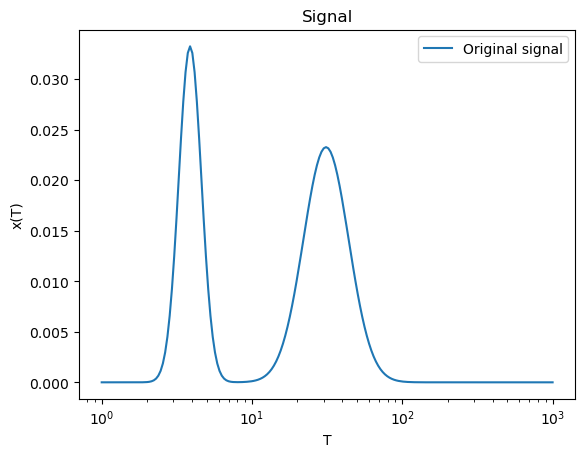

In [6]:
# Question 3
plot_signal(T, original=signal)

In [7]:
# Question 4

M = 50
tmin = 0
tmax = 1.5
m = np.arange(1, M + 1)
t = tmin + (m - 1) / (M - 1) * (tmax - tmin)

In [8]:
# Question 5

K = np.exp(-np.multiply(t[:, None], T[None, :]))
assert K.shape == (M, N)

In [9]:
# Question 6

z = K @ signal
sigma = 0.01 * z[0]
np.random.seed(2)  # To reproduce results, notably for the optimal choice of beta
y = z + np.random.normal(0, sigma, M)

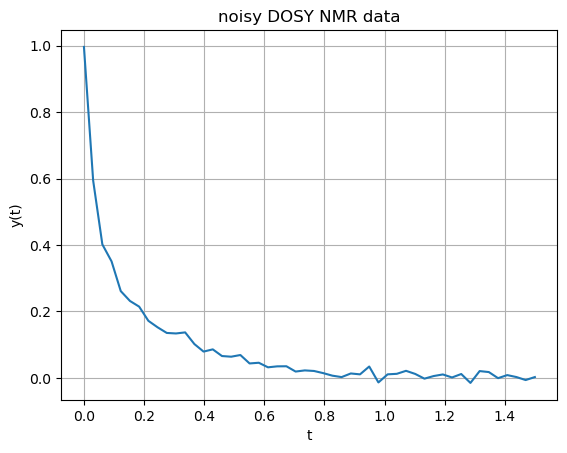

In [10]:
# Question 7

plt.plot(t, y)
plt.grid()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("noisy DOSY NMR data")
plt.show()

### 3) Comparison of regularization strategies

In this part, we denote
$$
    f(x) = \frac{1}{2} \|Kx - y\|^2
$$
and
$$
    h(x) = f(x) + g(x)
$$
with $g$ the chosen regularization function. h is the objective function of the problem.

In [11]:
f = lambda x: 1 / 2 * np.linalg.norm(K @ x - y) ** 2
df = lambda x: K.T @ (K @ x - y)

#### Smoothness prior

$$\hat{x}=\argmin_{x\in\R^N}\frac{1}{2}\|Kx-y\|^2+\frac{\beta}{2} \|Dx\|^2$$

<u>Question 1</u>

Let us remark that the objective function $h$ is twice differentiable on $\R^N$, and for all $x \in \R^N$, its gradient and Hessian are:
$$
    \nabla h(x) = K^T (Kx - y) + \beta D^T D x \quad \text{and} \quad \nabla^2 h(x) = K^T K + \beta D^T D.
$$

For all $x \in \R^N$, we have that $\ x^TK^TKx+\beta x^TD^TDx = \|Kx\|^2+\beta\|Dx\|^2 \geq 0$, so the objective function is clearly **convex**. Let us show that it is also **strictly** convex to get the uniqueness of the potential solution to the problem. For all $x \in \R^N$,
\begin{equation*}
    \begin{aligned}
        & x^T \nabla^2 h(x) x = 0\\
        \Leftrightarrow\, & x^T K^T K x + \beta x^T D^T D x = 0\\
        \Leftrightarrow\, & \| Kx \|^2 + \beta \| Dx \|^2 = 0\\
        \Leftrightarrow\, & \| Kx \|^2 = 0 \text{ and } \| Dx \|^2 = 0 \quad \text{(since all terms are positive and } \beta > 0 \text{)}\\
        \Leftrightarrow\, & x \in \mathrm{Ker}(K) \cap \mathrm{Ker}(D)
    \end{aligned}
\end{equation*}
Now, the definition of $D$ implies $x \in \mathrm{Ker}(D) \Rightarrow \exists \alpha \in \R, \ x = \alpha \mathbb{1}$ (where $\mathbb{1}$ is the vector with only $1$ as components). Then, $x \in \mathrm{Ker}(K) \Rightarrow Kx = \alpha K \mathbb{1}$ = 0. Consequently, since $K$ has only positive components and since we can assume that $K \neq 0$, this implies $\alpha = 0$, so $x = 0$. Therefore, $\mathrm{Ker}(K) \cap \mathrm{Ker}(D) = 0$, and thus $x^T \nabla^2 h(x) x = 0 \Rightarrow x = 0$. Therefore we showed that the Hessian of $h$ is positive definite, and thus $h$ is _strictly_ convex, which gives uniquess of the potential solution.

Since $h$ is convex, we also get that $\nabla h(x) = 0$ is a sufficient optimality condition, thus we can easily derive a closed-form solution to the problem:
\begin{equation*}
    \begin{aligned}
        & \nabla h(x) = 0\\
        \Leftrightarrow\, &  K^T (Kx - y) + \beta D^T D x = 0\\
        \Leftrightarrow\, & (K^T K + \beta D^T D)x = K^T y
    \end{aligned}
\end{equation*}
Our reasoning above showed that $K^T K + \beta D^T D$ is injective and thus invertible (since it is square-shaped), so we can invert it.

To conclude, we have the **existence and uniqueness** of the solution, given by
$$
    \boxed{x^* = (K^T K + \beta D^T D)^{-1} K^T y}
$$

<u>Question 2</u>

We have derived a closed-form solution, so we can simply implement it to get a solution.

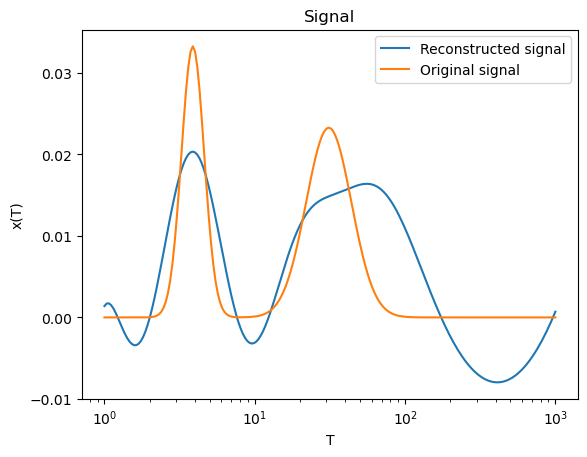

In [12]:
# Question 3

# Compute D
D = np.eye(N)
D[1:, :-1] -= np.eye(N - 1)
D[0, -1] = -1

beta = 1
x = np.linalg.inv(K.T @ K + beta * D.T @ D) @ K.T @ y
plot_signal(T, reconstruction=x, original=signal)

In [13]:
# Question 4
normalized_quadratic_error(signal, x)

0.42008410877489216

In [14]:
# Question 5
betas = np.arange(1.33, 1.34, 0.00001)
best_beta, best_error = None, np.inf
for beta in betas:
    x = np.linalg.inv(K.T @ K + beta * D.T @ D) @ K.T @ y
    error = normalized_quadratic_error(signal, x)
    if error < best_error:
        best_beta, best_error = beta, error
print("Best beta:", best_beta)

Best beta: 1.3399300000000651


The best value for $\beta$ is approximately $1.3393$, with a normalized quadratic error of $0.42$

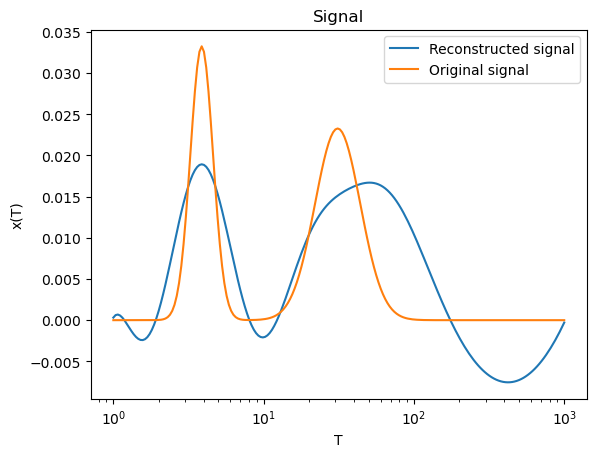

Normalized quadratic error: 0.41288746384992986


In [30]:
x = np.linalg.inv(K.T @ K + best_beta * D.T @ D) @ K.T @ y
plot_signal(T, reconstruction=x, original=signal)
print("Normalized quadratic error:", normalized_quadratic_error(signal, x))

Let us remark that we could also get the solution by gradient descent.

In this case, both functions $f$ and $g$ are differentiable on $\R^N$ with for all $x \in \R^N$:
\begin{equation}
    \nabla f(x) = K^T (Kx - y)
\end{equation}
and
\begin{equation}
    \nabla g(x) = \beta D^T Dx.
\end{equation}

In particular, $h$ is differentiable and its gradient is Lipschitz continuous. Indeed, for all $x_1 \in \R^N, \ x_2 \in \R^N$,
\begin{equation}
    \begin{aligned}
        \|\nabla h(x_1) - \nabla h(x_2)\| & = \|(K^T K + \beta D^T D)(x_1 - x_2)\| \\
         & \leq \|K^T K + \beta D^T D\| \|x_1 - x_2\|
    \end{aligned}
\end{equation}
with $\|A\|$ the spectral norm of matrix A. Therefore, $\nabla h$ is $\|K^T K + \beta D^T D\|-$ Lipschitz continuous.

Thereby, we can solve this problem by gradient descent. As a remark, we could also use the Forward-backward and Douglas-Rachford algorithms, as this function decomposes in $f + g$ with known proximal operator for $g$.

Value after 202000 iterations: 0.0026567342234254896
Early convergence after 202080 iterations
Final value: 0.0026567342281411123


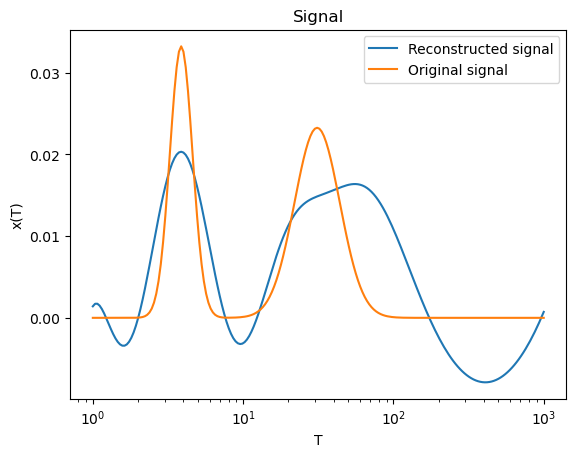

Normalized quadratic error: 0.41717743834480653


In [27]:
g = lambda x: best_beta / 2 * np.linalg.norm(D @ x) ** 2
dg = lambda x: D.T @ (D @ x)
h = lambda x: f(x) + g(x)
dh = lambda x: df(x) + dg(x)
gamma = np.linalg.norm(K.T @ K + best_beta * D.T @ D, ord=2)
x = gradient_descent(h, dh, np.zeros(N), lr_min=0.9 / gamma, lr_max=1.9 / gamma)
plot_signal(T, reconstruction=x, original=signal)
print("Normalized quadratic error:", normalized_quadratic_error(signal, x))

$\Rightarrow$ To summarize section on this prior, the best result is obtained with a closed-form solution, for a value $\beta$ of approximately $1.3393$, giving a normalized quadratic error of $0.42$

#### Smoothness prior + constraints

$$\hat{x}=\argmin_{x\in\R^N}\frac{1}{2}\|Kx-y\|^2+\frac{\beta}{2} \|Dx\|^2+ \mathbb{1}_{[x_{\text{min}},x_{\text{max}}]^N}(x)$$

<u>Question 1</u>

Thanks to the term $\mathbb{1}_{[x_{\text{min}},x_{\text{max}}]^N}(x)$, the problem can be reformulated on the non-empty, bounded (thus compact in dimension $N$) set $[x_{\text{min}},x_{\text{max}}]^N$ :

$$\hat{x}=\argmin_{x\in[x_{\text{min}},x_{\text{max}}]^N}\frac{1}{2}\|Kx-y\|^2+\frac{\beta}{2} \|Dx\|^2$$

Moreover, the objective is proper l.s.c. (lower semi-continuous), so by Weierstrass' theorem, the **existence of an optimal solution is guaranteed**. Furthermore, the objective function is strictly convex as showed for the previous regularization strategy, so we also have the **uniqueness** of the solution.

<u>Question 2</u>

Since the objective is differentiable as seen above, here with a convex constraint, we can use the projected gradient descent algorithm. Note that we could also use the forward-backward and Douglas-Rachford algorithms.

Value after 56000 iterations: 0.0027094589440830425
Early convergence after 56370 iterations
Final value: 0.0027094589278422823


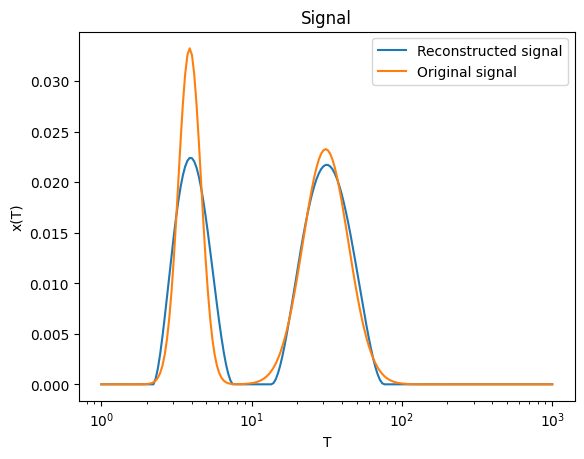

In [19]:
# Question 3
beta = 1
g = lambda x: beta / 2 * np.linalg.norm(D @ x) ** 2
dg = lambda x: D.T @ (D @ x)
h = lambda x: f(x) + g(x)
dh = lambda x: df(x) + dg(x)
gamma = np.linalg.norm(K.T @ K + beta * D.T @ D, ord=2)
x = projected_gradient_descent(h, dh, np.zeros(N), 0, 0.035, gamma, lr=0.9 / gamma)
plot_signal(T, reconstruction=x, original=signal)

In [20]:
# Question 4
normalized_quadratic_error(signal, x)

0.054655347608057084

In [21]:
# Question 5
betas = [0, 1, 10, 100, 500, 1000]
best_beta, best_error = None, np.inf
for beta in betas:
    print("beta =", beta)

    g = lambda x: beta / 2 * np.linalg.norm(D @ x) ** 2
    dg = lambda x: D.T @ (D @ x)
    h = lambda x: f(x) + g(x)
    dh = lambda x: df(x) + dg(x)
    gamma = np.linalg.norm(K.T @ K + beta * D.T @ D, ord=2)
    x = projected_gradient_descent(h, dh, np.zeros(N), 0, 0.035, gamma, lr=0.9 / gamma)

    error = normalized_quadratic_error(signal, x)
    print("Normalized quadratic error:", error)
    if error < best_error:
        best_beta, best_error = beta, error
    print()
print("Best beta:", best_beta)

beta = 0
Value after 56000 iterations: 0.0026520105842201642
Early convergence after 56368 iterations
Final value: 0.0026520093414770488
Normalized quadratic error: 0.05465534960029874

beta = 1
Value after 56000 iterations: 0.0027094589440830425
Early convergence after 56370 iterations
Final value: 0.0027094589278422823
Normalized quadratic error: 0.054655347608057084

beta = 10
Value after 56000 iterations: 0.0032264933619016935
Early convergence after 56390 iterations
Final value: 0.0032265050573843644
Normalized quadratic error: 0.054655332871301886

beta = 100
Value after 56000 iterations: 0.0083966348144169264
Early convergence after 56869 iterations
Final value: 0.008396929153876628
Normalized quadratic error: 0.05465495042674406

beta = 500
Value after 186000 iterations: 0.031287035231179386
Early convergence after 186800 iterations
Final value: 0.03128865624423259
Normalized quadratic error: 0.054559094600736935

beta = 1000
Value after 314000 iterations: 0.059400307328773486


Value after 186000 iterations: 0.031287035231179386
Early convergence after 186800 iterations
Final value: 0.03128865624423259


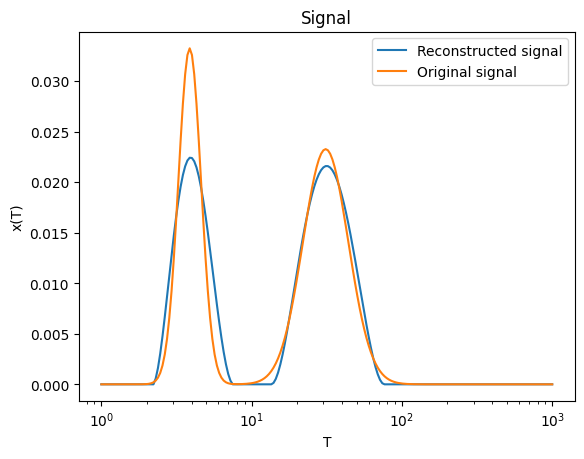

In [22]:
g = lambda x: best_beta / 2 * np.linalg.norm(D @ x) ** 2
dg = lambda x: D.T @ (D @ x)
h = lambda x: f(x) + g(x)
dh = lambda x: df(x) + dg(x)
gamma = np.linalg.norm(K.T @ K + best_beta * D.T @ D, ord=2)
x = projected_gradient_descent(h, dh, np.zeros(N), 0, 0.035, gamma, lr=0.9 / gamma)
plot_signal(T, reconstruction=x, original=signal)

In [23]:
normalized_quadratic_error(signal, x)

0.054559094600736935

$\Rightarrow$ For this prior, the best value for $\beta$ is $500$, giving a normalized error of $0.055$.

#### Sparsity prior

$$\hat{x} = \arg\min_{x\in\mathbb{R}^N} \frac{1}{2}\|Kx-y\|^2 + \frac{\beta}{2}\|x\|_1$$

<u>Question 1</u>

The term $\|x\|_1$ is coercive. Since the term $\frac{1}{2}\|Kx-y\|^2$ is positive, the sum of the two terms is coercive. Furthermore, it is proper and lower semi-continuous (l.s.c.), ensuring that the set of solutions to the problem is a non-empty compact set. Therefore, **the existence of a solution is guaranteed**. However, the solution is **not necessarily unique**, because this time the objective function is not necessarily strictly convex. A sufficient condition for strict convexity would be for $K^T K$ to be positive definite, which is not necessarily the case.

<u>Question 2</u>

We can use the Forward-Backward algorithm to solve this problem. We already computed the gradient of the first term, we just need the proximal operator of the second term which is well known to be the soft-thresholding operator.

Value after 31000 iterations: 0.012535757760043634
Early convergence after 31070 iterations
Final value: 0.012535738043230405


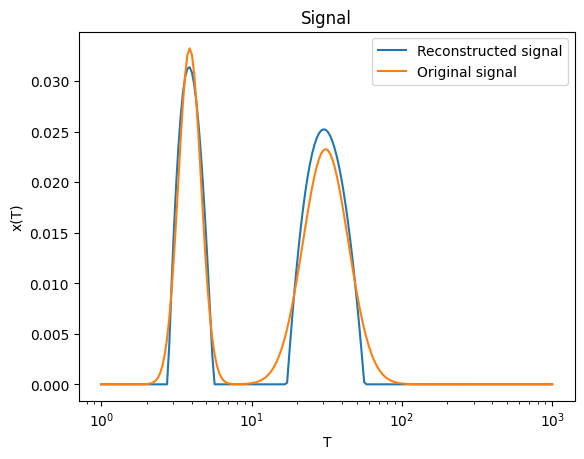

In [24]:
# Question 3
beta = 0.01
g = lambda x: beta * np.linalg.norm(x, ord=1)
nu = np.linalg.norm(K.T @ K, ord=2)


def prox_gamma_g(x, gamma):
    return np.sign(x) * np.maximum(np.abs(x) - beta * gamma, 0)


x = forward_backward(g, f, df, prox_gamma_g, np.zeros(N), 1.99 / nu, nu)
plot_signal(T, reconstruction=x, original=signal)

In [25]:
# Question 4
normalized_quadratic_error(signal, x)

0.02582392213615296

In [26]:
# Question 5
betas = [0, 0.001, 0.005, 0.006, 0.007, 0.01]
best_beta, best_error = None, np.inf
for beta in betas:
    print("beta =", beta)

    g = lambda x: beta * np.linalg.norm(x, ord=1)

    def prox_gamma_g(x, gamma):
        return np.sign(x) * np.maximum(np.abs(x) - beta * gamma, 0)

    x = forward_backward(
        g, f, df, prox_gamma_g, np.zeros(N), 1.99 / nu, nu, max_iter=50000
    )

    error = normalized_quadratic_error(signal, x)
    print("Normalized quadratic error:", error)
    if error < best_error:
        best_beta, best_error = beta, error
    print()
print("Best beta:", best_beta)

beta = 0
Value after 33000 iterations: 0.0025640472625883073
Early convergence after 33577 iterations
Final value: 0.002563660758876442
Normalized quadratic error: 0.37642064816567206

beta = 0.001
Value after 25000 iterations: 0.0036264397388354828
Early convergence after 25930 iterations
Final value: 0.0036259660061033006
Normalized quadratic error: 0.02466073500646089

beta = 0.005
Value after 23000 iterations: 0.007597562318146781
Early convergence after 23478 iterations
Final value: 0.007597340869732928
Normalized quadratic error: 0.020827412253754656

beta = 0.006
Value after 23000 iterations: 0.008588262316055719
Early convergence after 23615 iterations
Final value: 0.00858797490207093
Normalized quadratic error: 0.02077664995510962

beta = 0.007
Value after 23000 iterations: 0.009578027978290493
Early convergence after 23360 iterations
Final value: 0.009577855450839272
Normalized quadratic error: 0.020906143196880323

beta = 0.01
Value after 23000 iterations: 0.0125414845885170

Value after 23000 iterations: 0.008588262316055719
Early convergence after 23615 iterations
Final value: 0.00858797490207093


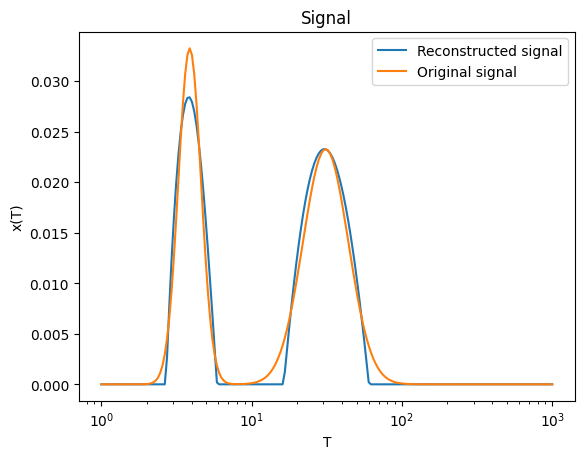

In [27]:
g = lambda x: best_beta * np.linalg.norm(x, ord=1)


def prox_gamma_g(x, gamma):
    return np.sign(x) * np.maximum(np.abs(x) - best_beta * gamma, 0)


x = forward_backward(g, f, df, prox_gamma_g, np.zeros(N), 1.99 / nu, nu, max_iter=50000)
plot_signal(T, reconstruction=x, original=signal)

In [28]:
# Question 4
normalized_quadratic_error(signal, x)

0.02077664995510962

We obtain a best $\beta$ equal to $0.006$, with an error of $0.021$.

Let us now try the same regularisation function, but using the Douglas-Rachford algorithm. The proximal operator of $\gamma f$ can be computed as:
\begin{equation}
    \boxed{prox_{\gamma f}(x) = (\gamma K^T K + I)^{-1} (\gamma K^T y + x)}
\end{equation}

Value after 39000 iterations: 1.1721016933092496
Early convergence after 39375 iterations
Final value: 1.1721019292957504


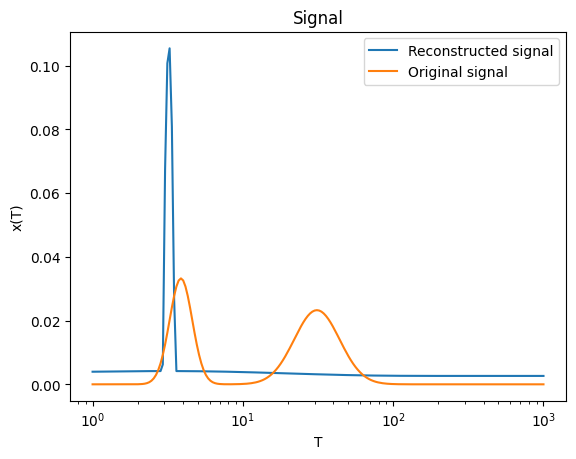

In [29]:
# Question 3
beta = 1
g = lambda x: beta * np.linalg.norm(x, ord=1)
nu = np.linalg.norm(K.T @ K, ord=2)


def prox_gamma_g(x, gamma):
    return np.sign(x) * np.maximum(np.abs(x) - beta * gamma, 0)


def prox_gamma_f(x, gamma):
    return np.linalg.inv(gamma * K.T @ K + np.eye(N)) @ (gamma * K.T @ y + x)


x = douglas_rachford(
    f, g, prox_gamma_f, prox_gamma_g, np.zeros(N), 1.99 / nu, max_iter=50000
)
plot_signal(T, reconstruction=x, original=signal)

In [30]:
# Question 4
normalized_quadratic_error(signal, x)

1.7393197522480668

In [31]:
# Question 5
betas = [0, 0.009, 0.01, 0.02, 0.1, 1]
best_beta, best_error = None, np.inf
for beta in betas:
    print("beta =", beta)

    g = lambda x: beta * np.linalg.norm(x, ord=1)

    def prox_gamma_g(x, gamma):
        return np.sign(x) * np.maximum(np.abs(x) - beta * gamma, 0)

    def prox_gamma_f(x, gamma):
        return np.linalg.inv(gamma * K.T @ K + np.eye(N)) @ (gamma * K.T @ y + x)

    x = douglas_rachford(
        f, g, prox_gamma_f, prox_gamma_g, np.zeros(N), 1.99 / nu, max_iter=10000
    )

    error = normalized_quadratic_error(signal, x)
    print("Normalized quadratic error:", error)
    if error < best_error:
        best_beta, best_error = beta, error
    print()
print("Best beta:", best_beta)

beta = 0


Value after 9000 iterations: 0.0025878875182831296
Early convergence after 9592 iterations
Final value: 0.0025872579141376574
Normalized quadratic error: 0.2579019571659513

beta = 0.009
Value after 9000 iterations: 0.011608009001543223
Early convergence after 9241 iterations
Final value: 0.011607846544526866
Normalized quadratic error: 0.028583984134524492

beta = 0.01
Value after 9000 iterations: 0.012605873706101912
Early convergence after 9256 iterations
Final value: 0.012605700551786551
Normalized quadratic error: 0.028508401787985027

beta = 0.02
Value after 9000 iterations: 0.022595064885135095
Early convergence after 9345 iterations
Final value: 0.022594836666052564
Normalized quadratic error: 0.02884733273013072

beta = 0.1
Value after 9000 iterations: 0.10321999979239732
Early convergence after 9698 iterations
Final value: 0.10321969658894052
Normalized quadratic error: 0.12850228647269035

beta = 1
Final value: 1.17208377790308241720907656231755
Normalized quadratic error: 1

Value after 24000 iterations: 0.012591839832523407
Early convergence after 24310 iterations
Final value: 0.012591773544670616


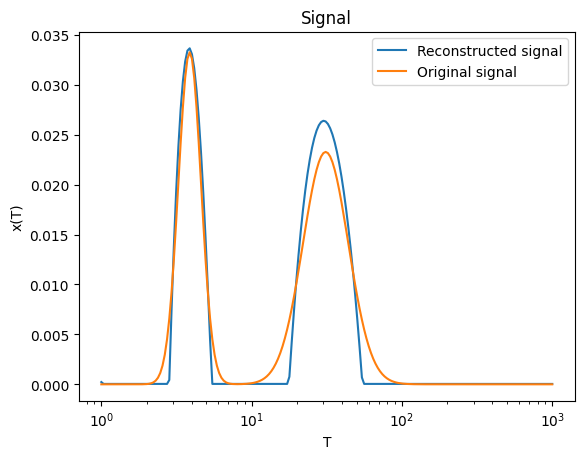

In [32]:
g = lambda x: best_beta * np.linalg.norm(x, ord=1)


def prox_gamma_g(x, gamma):
    return np.sign(x) * np.maximum(np.abs(x) - best_beta * gamma, 0)


def prox_gamma_f(x, gamma):
    return np.linalg.inv(gamma * K.T @ K + np.eye(N)) @ (gamma * K.T @ y + x)


x = douglas_rachford(
    f, g, prox_gamma_f, prox_gamma_g, np.zeros(N), 1.99 / nu, max_iter=50000
)
plot_signal(T, reconstruction=x, original=signal)

In [33]:
# Question 4
normalized_quadratic_error(signal, x)

0.03656307855798685

We obtain a best $\beta$ equal to $0.01$, with an error of $0.037$.

$\Rightarrow$ For this prior, the best result is obtained with Forward-Backward, wit a $\beta$ equal to $0.006$, and an error of $0.021$.

### To conclude this first part, we obtain the best result for a sparsity prior, using the forward-backward algorithm. Results are summarized in this table:

|              Prior             |        Method        | $\beta$ | Error |
|:------------------------------:|:--------------------:|:-------:|:-----:|
|        Smoothness prior        | Closed-form solution |  1.3393 | 0.420 |
| Smoothness prior + constraints |  Projected gradient  |   500   | 0.055 |
|         Sparsity prior         |   Forward-Backward   |  0.006  | 0.021 |

# Part 2

## Question 1

We first observe that $\forall x \in \R^N, \ ent(x) = \sum_{n=1}^N \phi(<e_n, x>)$ with $(e_n)_{n \in \{0, \dots, N\}}$ the canonical basis of $\R^N$.

$\cdot$ Now, $\mathrm{dom}(\phi) = \R^+$, so we clearly have $\mathrm{dom}(\mathrm{ent}) = (\R^+)^N$, so **$\mathrm{ent}$ is proper**.

$\cdot$ Furthermore, $\phi$ is clearly continuous on $\R^{+*}$. It is also continuous in $0$. Indeed,
\begin{equation}
    \forall x \in R, \ x \log(x) = \frac{log(x)}{1/x}.
\end{equation}
Now,
\begin{equation}
        \frac{1}{x} \xrightarrow[x \to 0^+]{} \infty
\end{equation}
and
\begin{equation}
        \frac{\frac{\partial (\log)}{\partial x}(x)}{\frac{\partial (\frac{1}{x})}{\partial x}(x)} = \frac{\frac{1}{x}}{\frac{-1}{x^2}} = -x \xrightarrow[x \to 0^+]{} 0.
\end{equation}
So, by L'Hospital's rule, $x \log(x) \xrightarrow[x \to 0^+]{} 0$.

 Therefore, since $\forall n \in \{0, \dots, N\}, \ \forall x \in (\R \times \dots \times \underbrace{\R^+}_{n} \times \dots \times \R) \ <e_n, x> \in \R^+$, we clearly get that $\mathrm{ent}$ is **continuous (and hence l.s.c.)** on $\mathrm{dom}(\mathrm{ent}) = (\R^+)^N$.

$\cdot$ $\mathrm{ent}$ is **twice differentiable** on $\R^{+*}$ and for all $x \in \R^{+*}$, its gradient is
\begin{equation}
    \nabla{\mathrm{ent}}(x) = \begin{pmatrix} \log(x_1) + 1 \\ \vdots \\ \log(x_N) + 1 \end{pmatrix}
\end{equation}
and its hessian is
\begin{equation}
    \nabla^2 \mathrm{ent}(x) = \begin{pmatrix}
        \frac{1}{x_1} & 0 & \dots & 0\\
        0 & \ddots & & \vdots\\
        \vdots & & \ddots & 0\\
        0 & \dots & 0 & \frac{1}{x_N}
    \end{pmatrix}
\end{equation}

$\cdot$ The hessian is clearly positive definite since it is diagonal with positive terms, so $\mathrm{ent}$ is **strictly convex on $(\R^{+*})^N$**. Since $\mathrm{ent}$ is continuous on $(\R^+)^N$, we can show that the strict convexity extends to $(R^{+})^N$.

## Question 2

We have that $\phi(x) \xrightarrow[x \to \infty]{} +\infty$, so $\phi$ is coercive on $\R^+$ which is a closed convex set. Therefore, it has a minimum $m \in \R$.

Then, $\forall x \in (\R^+)^N, \ \mathrm{ent}(x) \geq (N-1)m + \max_{n \in \{1, \dots, N\}} \phi(x_n) \xrightarrow[\|x\| \to +\infty]{} +\infty$, so $\mathrm{ent}$ is coercive on $(\R^+)^N$ which is a closed convex set. Since $\|Kx - y\|^2 \geq 0$, the objective function is also coercive on this set, so **we have the existence of a solution to the problem**.

The Hessian of the objective function on $(\R^{+*})^N$ is $K^T K +
\beta \begin{pmatrix}
    \frac{1}{x_1} & 0 & \dots & 0\\
    0 & \ddots & & \vdots\\
    \vdots & & \ddots & 0\\
    0 & \dots & 0 & \frac{1}{x_N}
\end{pmatrix}$, which is positive definite on $(\R^{+*})^N$, and we can show that the strict convexity extends to $(\R^+)^N$. Therefore, **we have the uniqueness of the solution**.

## Question 3

Let $x \in \R^N$ and let $\gamma > 0$. Let $f_x : y \in (\R^+)^N \mapsto \gamma \mathrm{ent}(y) + \frac{1}{2} \| x - y \|^2$.

$\gamma f_x$ is differentiable with gradient:
\begin{equation}
    \nabla(\gamma f_x)(y) = \gamma (\log(y) + 1) + y - x
\end{equation}
(where $\log(y)$ is the component-wise logarithm and $1$ is the vector with only $1$ as components).
Then, since we are in a convex case and we know that $\gamma f_x$ has a unique minimum according to the course, a sufficient condition for $y$ to be the minimum of $\gamma f_x$ is:
\begin{equation}
    \begin{aligned}
        & \nabla(\gamma f_x)(y) = 0\\
        \Leftrightarrow & \forall n, \gamma \log(y_n) + y_n = x_n - \gamma \\
        \Leftrightarrow & \forall n, \gamma (\log(y_n) + \frac{y_n}{\gamma}) = x_n - \gamma \\
        \Leftrightarrow & \forall n, \log(y_n \exp(\frac{y_n}{\gamma})) = \frac{x_n - \gamma}{\gamma} \\
        \Leftrightarrow & \forall n, \log(\frac{y_n}{\gamma} \exp(\frac{y_n}{\gamma})) = \frac{x_n - \gamma}{\gamma} - \log(\gamma) \\
    \end{aligned}
\end{equation}
Finally, using the W-Lambert function $W$,
\begin{equation}
    \Leftrightarrow y_n = \gamma W \left(\frac{\exp\left(\frac{x_n - \gamma}{\gamma}\right)}{\gamma}\right).
\end{equation}

So, by definition of the proximal operator,
$$\boxed{\mathrm{prox}_{\gamma f} : x \mapsto \gamma W \left(\frac{\exp\left(\frac{x - \gamma}{\gamma}\right)}{\gamma}\right)}$$
(where $W$ is here understood as the component-wise W-Lambert function).

## Question 4

The objective function decomposes in $f + g$ where $f: x \in \R^N \mapsto \frac{1}{2} \| Kx - y \|^2$ and $g = \beta \mathrm{ent}$.

Since both functions are proper, l.s.c. and convex, since $f$ is differentiable with a known gradient $K^T (Kx - y)$ which is $\|K^T K\|-$ Lipschitz continuous, and since $g$ has a known proximal (as explicited in the previous question), we can use the forward-backward algorithm. We also know a proximal operator for $f$, namely:
\begin{equation}
    prox_{\gamma f}(x) = (\gamma K^T K + I)^{-1} (\gamma K^T y + x),
\end{equation}
so we can also use the Douglas-Rachford algorithm.

## Question 5

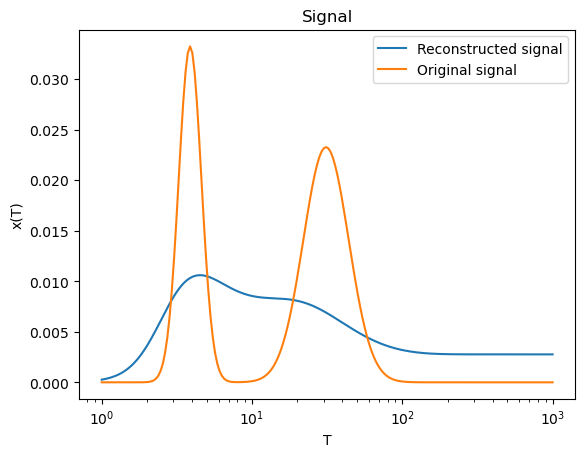

In [40]:
f = lambda x: 1 / 2 * np.linalg.norm(K @ x - y) ** 2
df = lambda x: K.T @ (K @ x - y)
nu = np.linalg.norm(K.T @ K, ord=2)
beta = 1e-2


def ent(x):
    result = beta * (x > 0) * x * np.log(x)
    print(result)
    result[np.where(x < 0)] = np.inf
    return result


prox_gamma_ent = (
    lambda x, gamma: beta
    * gamma
    * lambertw(1 / gamma / beta * np.exp(x / gamma / beta - 1)).real
)

x = forward_backward(
    ent, f, df, prox_gamma_ent, np.zeros(N), 1.99 / nu, nu, verbose=False
)
plot_signal(T, reconstruction=x, original=signal)

In [41]:
normalized_quadratic_error(signal, x)

0.5407114024019612

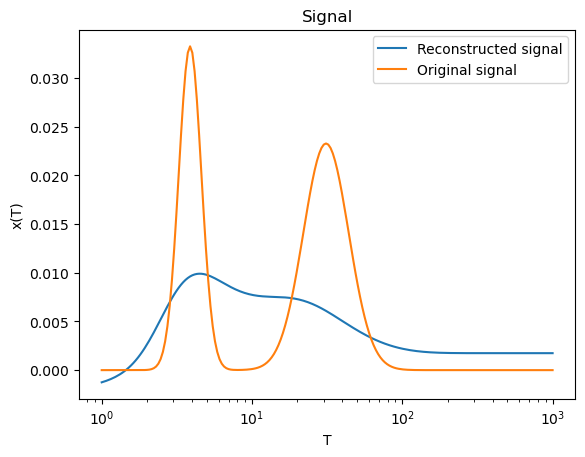

In [42]:
def prox_gamma_f(x, gamma):
    return np.linalg.inv(gamma * K.T @ K + np.eye(N)) @ (gamma * K.T @ y + x)


x = douglas_rachford(
    f, ent, prox_gamma_f, prox_gamma_ent, np.zeros(N), 10 / nu, verbose=False
)
plot_signal(T, reconstruction=x, original=signal)

In [43]:
normalized_quadratic_error(signal, x)

0.5392440959500203

## Question 6

Forward-Backward algorithm:

In [44]:
# Forward-backward
betas = np.arange(0.0056, 0.0061, 0.0001)
best_beta, best_error = None, np.inf
for beta in betas:

    def ent(x):
        result = beta * (x > 0) * x * np.log(x)
        print(result)
        result[np.where(x < 0)] = np.inf
        return result

    prox_gamma_ent = (
        lambda x, gamma: beta
        * gamma
        * lambertw(1 / gamma / beta * np.exp(x / gamma / beta - 1)).real
    )

    x = forward_backward(
        ent, f, df, prox_gamma_ent, np.zeros(N), 1.99 / nu, nu, verbose=False
    )

    error = normalized_quadratic_error(signal, x)
    if error < best_error:
        best_beta, best_error = beta, error
print("Best beta:", best_beta)

C:\Users\Theilo\AppData\Local\Temp\ipykernel_10892\496823558.py:15: RuntimeWarning: overflow encountered in multiply
  * lambertw(1 / gamma / beta * np.exp(x / gamma / beta - 1)).real
C:\Users\Theilo\AppData\Local\Temp\ipykernel_10892\591628668.py:2: RuntimeWarning: invalid value encountered in matmul
  df = lambda x: K.T @ (K @ x - y)
C:\Users\Theilo\AppData\Local\Temp\ipykernel_10892\2588344892.py:72: RuntimeWarning: invalid value encountered in subtract
  y = x - gamma * dg(x)


Best beta: 0.0057


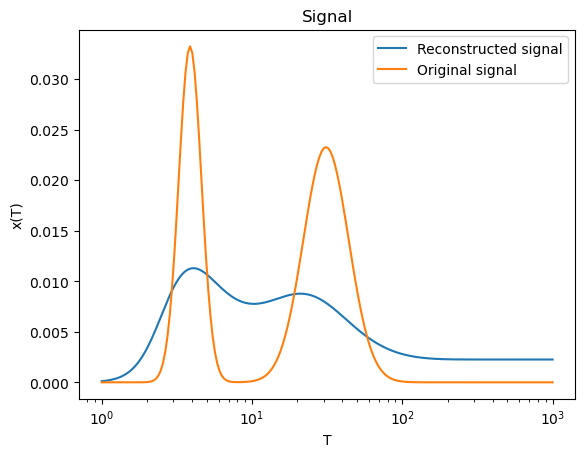

In [45]:
def ent(x):
    result = best_beta * (x > 0) * x * np.log(x)
    print(result)
    result[np.where(x < 0)] = np.inf
    return result


prox_gamma_ent = (
    lambda x, gamma: best_beta
    * gamma
    * lambertw(1 / gamma / best_beta * np.exp(x / gamma / best_beta - 1)).real
)

x = forward_backward(
    ent, f, df, prox_gamma_ent, np.zeros(N), 1.99 / nu, nu, verbose=False
)
plot_signal(T, reconstruction=x, original=signal)

In [46]:
normalized_quadratic_error(signal, x)

0.4743944923686851

Douglas-Rachford:

In [47]:
# Douglas-Rachford
betas = np.arange(9.45e-5, 1e-4, 1e-6)
best_beta, best_error = None, np.inf
for beta in betas:

    def ent(x):
        result = beta * (x > 0) * x * np.log(x)
        print(result)
        result[np.where(x < 0)] = np.inf
        return result

    prox_gamma_ent = (
        lambda x, gamma: beta
        * gamma
        * lambertw(1 / gamma / beta * np.exp(x / gamma / beta - 1)).real
    )

    x = douglas_rachford(
        f, ent, prox_gamma_f, prox_gamma_ent, np.zeros(N), 250 / nu, verbose=False
    )

    error = normalized_quadratic_error(signal, x)
    if error < best_error:
        best_beta, best_error = beta, error
print("Best beta:", best_beta)

Best beta: 9.949999999999999e-05


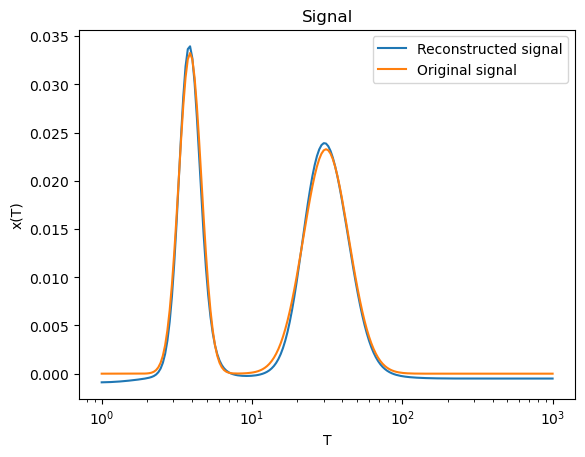

In [48]:
def ent(x):
    result = best_beta * (x > 0) * x * np.log(x)
    print(result)
    result[np.where(x < 0)] = np.inf
    return result


prox_gamma_ent = (
    lambda x, gamma: best_beta
    * gamma
    * lambertw(1 / gamma / best_beta * np.exp(x / gamma / best_beta - 1)).real
)

x = douglas_rachford(
    f,
    ent,
    prox_gamma_f,
    prox_gamma_ent,
    np.zeros(N),
    250 / nu,
    verbose=False,
    max_iter=10000,
)
plot_signal(T, reconstruction=x, original=signal)

In [43]:
normalized_quadratic_error(signal, x)

0.00421294158887203

The best choice of beta is $0.0057$ for the Forward-Backward algorithm and $9.95\times 10^{-5}$ for Douglas-Rachford.

## Question 7

We get the best results with the entropy regularization, using Douglas-Rachford with a final error of $0.0042$. However, this method is also harder to fit because the parameter $\beta$ has to be chosen very precisely.

## Question 8

We have the following problem to solve:
$$\min_{x \in \R^N} \text{ent}(x) \quad{\mathrm{subject~to}}\quad\|K x-y\|^{2}\leq\eta M\sigma^{2}$$
Let us remark that, denoting $g_1 = \mathrm{ent}$ and $g_2 = \iota_{\mathcal{B}(y, \sqrt{\eta M}\sigma)}$ (where $\mathcal{B}(c, \rho)$ is the closed ball of center $c$ and radius $\rho$), the problem rewrites:
$$
\min_{x \in \R^N} g_1(x) + g_2(Kx);
$$
that is, denoting $L_1 = I_N$ and $L_2 = K$:
$$
\min_{x \in \R^N} g_1(L_1 x) + g_2(L_2 x).
$$
Therfore, we will want to use the PPXA+ algorithm, for which we show that we fall within the required hypotheses:
- $g_1$ is proper, l.s.c. and convex (as proven in question 1 of part 2).
- $g_2$ is also proper, l.s.c. and convex (since $\mathcal{B}(y, \sqrt{\eta M}\sigma)$ is non-empty, closed and convex).
- $L_1^T L_1 + l_2^T L_2 = I_N + K^T K$ is invertible. Indeed, it is symmetric and thus diagonalizable with eigenvalues $\lambda_i + 1$, where the $\lambda_i$ are the eigenvalues of $K$. Since the $\lambda_i$ are non-negative, the $\lambda_i + 1$ are all positive, and thus $I_N + K^T K$ is invertible.

Therefore, **we can apply the PPXA+ algorithm**. In this case, for $\gamma >0$, the proximal operators of $\gamma g_1$ is:
$$\boxed{\text{prox}_{\gamma g_1} (x) = \gamma W \left(\frac{\exp\left(\frac{x - \gamma}{\gamma}\right)}{\gamma}\right)}$$
Next, $\gamma g_2 = \gamma \iota_{\mathcal{B}(y, \sqrt{\eta M}\sigma)} = \iota_{\mathcal{B}(y, \sqrt{\eta M}\sigma)} = \iota_{\mathcal{B}(0, \sqrt{\eta M}\sigma)}(\cdot - y)$. So, for all $z \in \R^M$,
\begin{equation*}
    \begin{aligned}
        \text{prox}_{\gamma g_2} (z) &= \mathrm{prox}_{\iota_{\mathcal{B}(0, \sqrt{\eta M}\sigma)}(\cdot - y)}(z)\\
        & = y + \mathrm{prox}_{\iota_{\mathcal{B}(0, \sqrt{\eta M}\sigma)}} (z-y)\\
        & = y + (z - y) - \mathrm{prox}_{\sqrt{\eta M}\sigma \|\cdot\|_2}(z-y)\\
        & = z - (1 - \frac{\sqrt{\eta M }\sigma}{\max(\|z-y\|_2, \sqrt{\eta M }\sigma)})(z-y)\\
    \end{aligned}
\end{equation*}
$$
\boxed{\text{prox}_{\gamma g_2} (z) = y + \frac{\sqrt{\eta M }\sigma}{\max(\|z-y\|_2, \sqrt{\eta M }\sigma)} (z-y)}
$$

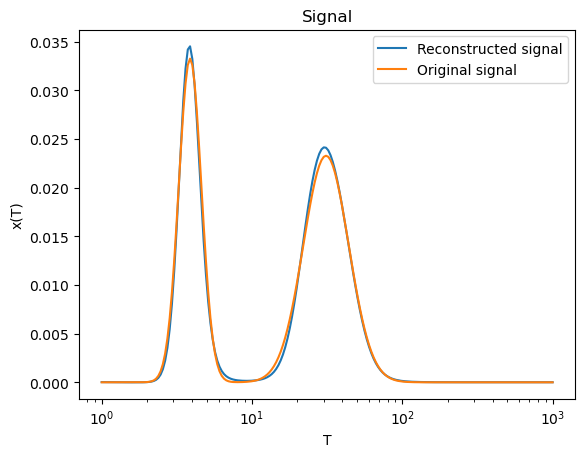

Normalized quadratic error: 0.002536121691894494


In [22]:
eta = 1

g2 = lambda z: np.linalg.norm(z-y)**2 <= eta*M*sigma**2

prox_gamma_g2 = lambda z, gamma: (
    y +
    (np.sqrt(eta * M) * sigma) / (np.maximum(np.linalg.norm(z-y),np.sqrt(eta * M) * sigma))
    * (z-y)
)

gamma = np.sqrt(eta * M) * sigma
L1 = np.eye(N)
L2 = K
x01 = np.zeros(N)
x02 = np.zeros(M)

x = ppxa(ent, g2, prox_gamma_ent, prox_gamma_g2, L1, L2, x01, x02, gamma, tol=1e-6, max_iter=50000, verbose=False)
plot_signal(T, reconstruction=x, original=signal)
print("Normalized quadratic error:", normalized_quadratic_error(signal, x))

In [80]:
# Find best value for eta
etas = np.arange(1, 1.04, 0.005)
best_eta, best_error = None, np.inf
for eta in etas:

    g2 = lambda z: np.linalg.norm(z-y)**2 <= eta*M*sigma**2

    prox_gamma_g2 = lambda z, gamma: (
        y +
        (np.sqrt(eta * M) * sigma) / (np.maximum(np.linalg.norm(z-y),np.sqrt(eta * M) * sigma))
        * (z-y)
    )

    x = ppxa(ent, g2, prox_gamma_ent, prox_gamma_g2, L1, L2, x01, x02, gamma, tol=1e-6, max_iter=50000, verbose=False)

    error = normalized_quadratic_error(signal, x)
    if error < best_error:
        best_eta, best_error = eta, error
print("Best eta:", best_eta)

Best eta: 1.0349999999999993


In [31]:
# Find best value for eta
etas = np.arange(0.99, 1.02, 0.005)
best_eta, best_error = None, np.inf
for eta in etas:

    g2 = lambda z: np.linalg.norm(z-y)**2 <= eta*M*sigma**2

    prox_gamma_g2 = lambda z, gamma: (
        y +
        (np.sqrt(eta * M) * sigma) / (np.maximum(np.linalg.norm(z-y),np.sqrt(eta * M) * sigma))
        * (z-y)
    )

    x = ppxa(ent, g2, prox_gamma_ent, prox_gamma_g2, L1, L2, x01, x02, gamma, tol=1e-6, max_iter=50000, verbose=False)

    error = normalized_quadratic_error(signal, x)
    if error < best_error:
        best_eta, best_error = eta, error
print("Best eta:", best_eta)

Best eta: 1.01


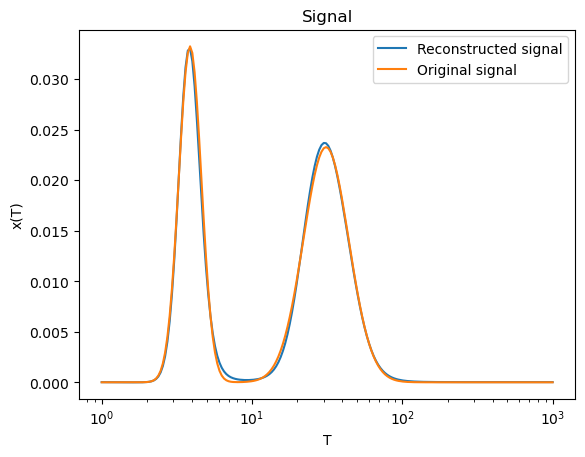

Normalized quadratic error: 0.001684992674782691


In [32]:
g2 = lambda z: np.linalg.norm(z-y)**2 <= best_eta*M*sigma**2

prox_gamma_g2 = lambda z, gamma: (
    y +
    (np.sqrt(best_eta * M) * sigma) / (np.maximum(np.linalg.norm(z-y),np.sqrt(eta * M) * sigma))
    * (z-y)
)

x = ppxa(ent, g2, prox_gamma_ent, prox_gamma_g2, L1, L2, x01, x02, gamma, tol=1e-6, max_iter=50000, verbose=False)
plot_signal(T, reconstruction=x, original=signal)
print("Normalized quadratic error:", normalized_quadratic_error(signal, x))

We get the best result with this new formulation of the problem and using the PPXA+ algorithm, with a final error of $0.0017$. Furthermore, we could obtain a satisfying value of $\eta$ easily by looking for values near $1$. The best value for eta is approximately $1.01$.